# XGBoost

In [12]:
import pandas as pd
import numpy as np
from numpy import sqrt
from xgboost import XGBClassifier
from numpy import argmax
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

## Dataframes

In [13]:
df_public = pd.read_csv('dados/public.csv')
df_metar = pd.read_csv('dados/metar.csv', index_col=0, low_memory=False)

## Tratamento

In [14]:
# variáveis para junção
df_public['data_ref'] = df_public['hora_ref'].apply(lambda x: x[:7])
df_metar['date'] = df_metar['date'].apply(lambda x: x[:7])

In [15]:
df_model = df_public.merge(df_metar, how='left', left_on=['metar', 'data_ref'], right_on=['meta', 'date'])

In [16]:
# variáveis de data
df_model['ano'] = np.int64(df_model['hora_ref'].str[:4])
df_model['mes'] = np.int64(df_model['hora_ref'].str[5:7])
df_model['dia'] = np.int64(df_model['hora_ref'].str[8:10])
df_model['hora'] = np.int64(df_model['hora_ref'].str[11:13])

# variáveis categóricas
df_model['origem'] = df_model['origem'].astype('category')
df_model['destino'] = df_model['destino'].astype('category')

cat_columns = df_model.select_dtypes(['category']).columns
df_model[cat_columns] = df_model[cat_columns].apply(lambda x: x.cat.codes)

## Seleção de variáveis

In [17]:
df_model = df_model[[
    'ano',
    'mes',
    'dia',
    'hora',
    'origem',
    'destino',
    'prev_troca_cabeceira',
    'troca_cabeceira_hora_anterior',
    'espera',
    'latitude',
    'longitude',
    'elevation',
    'wind_direction',
    'wind_speed',
    'visibility',
    'low_cloud_level',
    'cloud_coverage',
    'air_temperature',
    'dew_point_temperature',
    'altimeter',
    'current_wx1_symbol',
    'current_wx2_symbol',
    'current_wx3_symbol',
    'air_pressure_at_sea_level',
    'eastward_wind',
    'northward_wind'
]]

## Datasets de Treino e Teste

In [18]:
# Dataframe para envio na competição
df_test_final = df_model[df_model.espera.isnull()].drop('espera',axis=1)

# Dataframes de treino e teste
df_train_inicial = df_model[~df_model.espera.isnull()]
df_train_inicial = df_train_inicial.dropna()
X_train_inicial = df_train_inicial.drop('espera', axis=1)
y_train_inicial = df_train_inicial['espera']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_inicial, y_train_inicial, test_size=0.20, random_state=42, stratify=y_train_inicial)

## Parâmetros

In [19]:
positives = y_train.sum()
negatives = y_train.shape[0] - y_train.sum()
spw = negatives/positives

In [20]:
spw

56.154421768707486

In [21]:
space={'max_depth': hp.quniform("max_depth", 3, 20, 1),
        'min_child_weight' : hp.lognormal('min_child_weight', 7, 3),
        'n_estimators': hp.quniform('n_estimators', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0.1,  1),
        'scale_pos_weight':hp.quniform('scale_pos_weight', 45, 65, 1),
        'treshold': hp.uniform('treshold', 0.5,  0.8),
    }

In [22]:
# Classifier:
def hyperparameter_tuning(space):
    model = XGBClassifier(n_estimators=int(space['n_estimators']),
                          max_depth = int(space['max_depth']),
                         min_child_weight=int(space['min_child_weight']),
                         learning_rate= space['learning_rate'],
                         objective='binary:logistic',
                         tree_method="auto",
                         scale_pos_weight=space['scale_pos_weight'],
                        #  booster='dart',
                         enable_categorical=True)
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    model.fit(X_train, y_train,
            eval_set=evaluation, 
            verbose=False)

    pred = model.predict(X_test)
    auc = roc_auc_score(y_test, pred>space['treshold'])
    print('Atrasados: ' + str(pred.sum()) + ' || '+ "AUC: " + str(auc))
    #change the metric if you like
    return {'loss': 1 - auc, 'status': STATUS_OK, 'model': model}

In [23]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=11354,
            trials=trials)
print(best)

Atrasados: 13489 || AUC: 0.7070186993244746              
Atrasados: 10681 || AUC: 0.7327266362279757                                        
Atrasados: 0 || AUC: 0.5                                                            
Atrasados: 9913 || AUC: 0.7510313356335411                                          
Atrasados: 10370 || AUC: 0.7143377804676166                                         
Atrasados: 9778 || AUC: 0.7422809536665371                                          
Atrasados: 9262 || AUC: 0.7298374328652816                                          
Atrasados: 5377 || AUC: 0.7353577831772338                                          
Atrasados: 7013 || AUC: 0.7591593462504933                                          
Atrasados: 6891 || AUC: 0.7516362526984918                                          
Atrasados: 10105 || AUC: 0.7507825749866744                                         
Atrasados: 13566 || AUC: 0.7233955655237818                                         
Atrasado

## Treino

In [27]:
bst = XGBClassifier(
    learning_rate= 0.1949090884904199,
      max_depth= 19,
      min_child_weight=187.2734038961501,
      n_estimators= 19,
        scale_pos_weight= 63.0,
    # booster='dart',
    enable_categorical=True)

In [28]:
_ = bst.fit(X_train, y_train)

## Teste

In [31]:
y_pred = bst.predict_proba(X_test)[:,1]

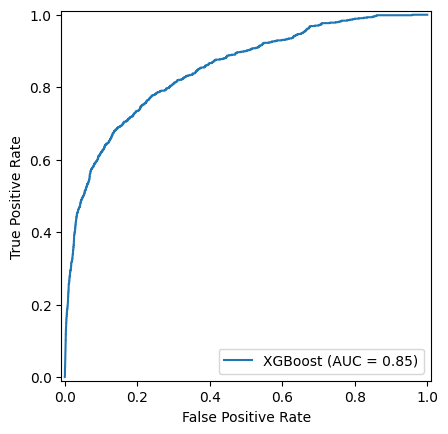

In [32]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='XGBoost')
display.plot()
plt.show()

## Otimização do Threshold Probabilístico

### ROC

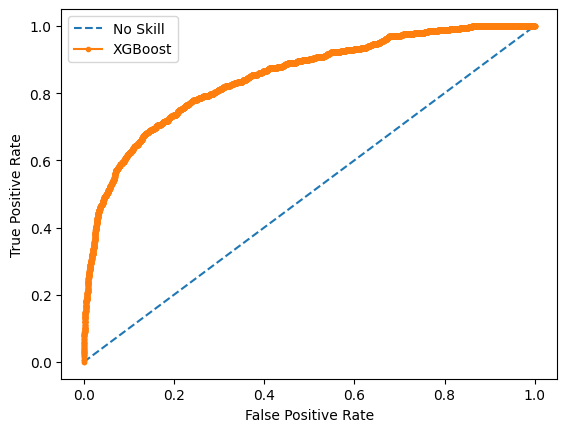

In [33]:
# calcula a curva
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# grafico 
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')

# titulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [34]:
# calcula o melhor ponto 
gmeans = sqrt(tpr * (1-fpr))
ix = argmax(gmeans)


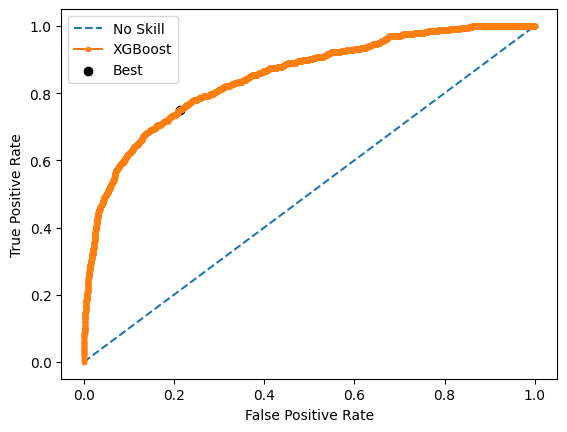

In [35]:
# plota o melhor ponto
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='XGBoost')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')

# titulos
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.show()

In [36]:
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.408568, G-Mean=0.769


### PRC

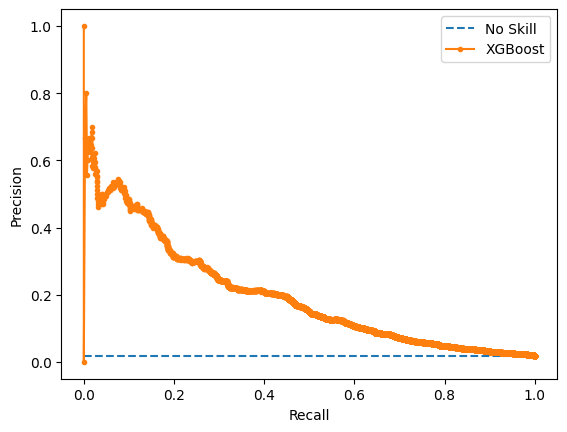

In [37]:
# calcula a curva
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# grafico 
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGBoost')

# titulos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [38]:
# medida F
fscore = (2 * precision * recall) / (precision + recall + 0.00001)

# índice do maior F
ix = argmax(fscore)

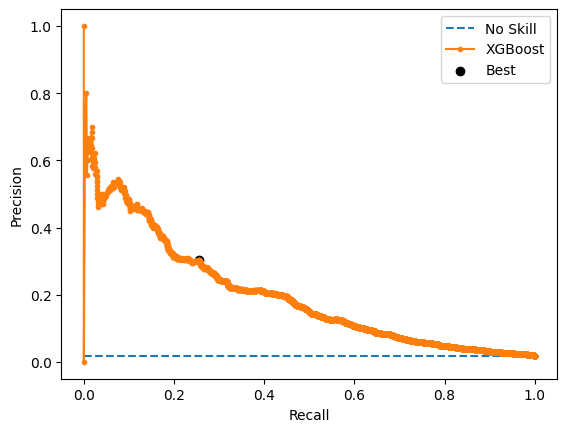

In [39]:
# plota o melhor ponto
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')

# titulos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.show()

In [40]:
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.863149, F-Score=0.277


## Submissão

In [47]:
# ids
sub = df_public[df_public.espera.isnull()].drop('espera',axis=1).flightid

# threshold escolhido
threshold = 0.7177434201119826

# submissao
sub = pd.DataFrame(sub)
y_pred_final = bst.predict_proba(df_test_final)[:,1]
sub['espera'] = np.int8(y_pred_final > threshold)

# informacoes
print(f'Métrica F1 na validação: {f1_score(y_test, np.int8(y_pred > threshold))}')
print(f'{sub.espera.sum()} de {sub.shape[0]} voos classificados como atrasados com threshold {threshold}')


sub.to_csv('submissions/submission_xgboost.csv', index=False)

Métrica F1 na validação: 0.23748773307163887
3346 de 90720 voos classificados como atrasados com threshold 0.7177434201119826
